In [3]:
pip install --upgrade tensorflow keras tensorflow-addons


Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MultiHeadAttention, LayerNormalization, Input

# Define the path to your dataset
train_dir = r"C:\Users\ASUS\Downloads\MAD\archive\Train"
test_dir = r"C:\Users\ASUS\Downloads\MAD\archive\Test"

# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  
)

class VisionTransformer(tf.keras.Model):
    def __init__(self, num_classes):
        super(VisionTransformer, self).__init__()
        self.flatten = Flatten()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attention = MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.1)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dense1 = Dense(128, activation='relu')
        self.dropout = Dropout(0.5)
        self.dense2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.norm1(x)
        x = tf.reshape(x, (tf.shape(x)[0], -1, 64))  
        x = self.attention(x, x)
        x = tf.reduce_mean(x, axis=1)
        x = self.norm2(x)
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)

model = VisionTransformer(num_classes=len(train_generator.class_indices))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('sign_language_vit_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

model.save('sign_language_final_vit_model.keras')


Found 21974 images belonging to 24 classes.
Found 5481 images belonging to 24 classes.
Epoch 1/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 249s 354ms/step - accuracy: 0.0882 - loss: 3.0922 - val_accuracy: 0.1578 - val_loss: 2.7464 - learning_rate: 0.0010
Epoch 2/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 213s 310ms/step - accuracy: 0.1833 - loss: 2.6363 - val_accuracy: 0.2208 - val_loss: 2.4889 - learning_rate: 0.0010
Epoch 3/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 98s 142ms/step - accuracy: 0.2347 - loss: 2.4260 - val_accuracy: 0.2625 - val_loss: 2.3408 - learning_rate: 0.0010
Epoch 4/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 97s 141ms/step - accuracy: 0.2695 - loss: 2.2891 - val_accuracy: 0.3122 - val_loss: 2.1894 - learning_rate: 0.0010
Epoch 5/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 97s 141ms/step - accuracy: 0.3121 - loss: 2.1663 - val_accuracy: 0.3237 - val_loss: 2.1198 - learning_rate: 0.0010
Epoch 6/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 97s 141ms/step - accuracy: 0.3410 - loss: 2.0583 - val_accuracy: 0.3549 - val_loss: 2.0039 - lea

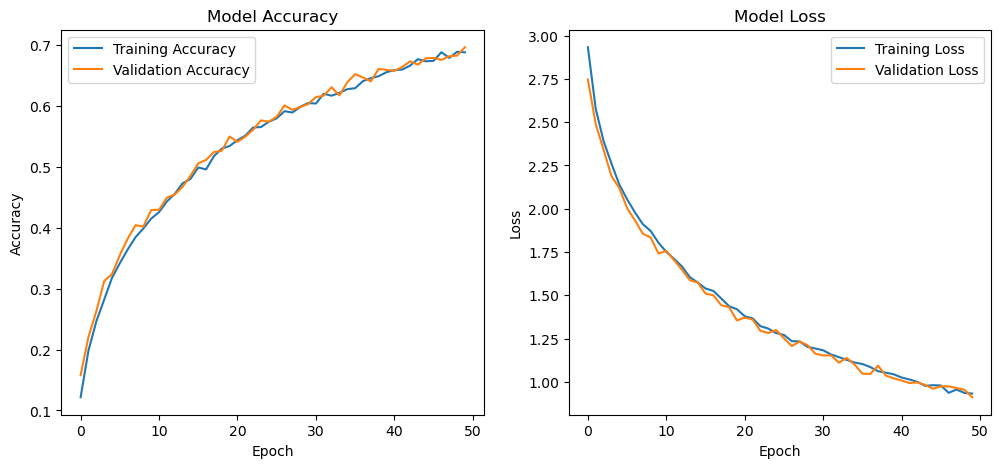

Found 7172 images belonging to 24 classes.
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - accuracy: 0.8109 - loss: 0.5771
Test Accuracy: 77.69%
Test Loss: 0.6392
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step
Classification Report:

              precision    recall  f1-score   support

           A       0.98      0.95      0.97       331
           B       0.89      0.99      0.93       432
           C       0.99      0.71      0.83       310
           D       0.49      0.38      0.43       245
           E       0.86      0.57      0.69       498
           F       0.88      0.96      0.92       247
           G       0.89      0.91      0.90       348
           H       0.97      0.85      0.90       436
           I       0.74      0.61      0.67       288
           K       0.86      0.89      0.88       331
           L       0.55      0.92      0.69       209
           M       0.63      0.92      0.75       394
           N       0.75      0.66      0.70       291
           O   

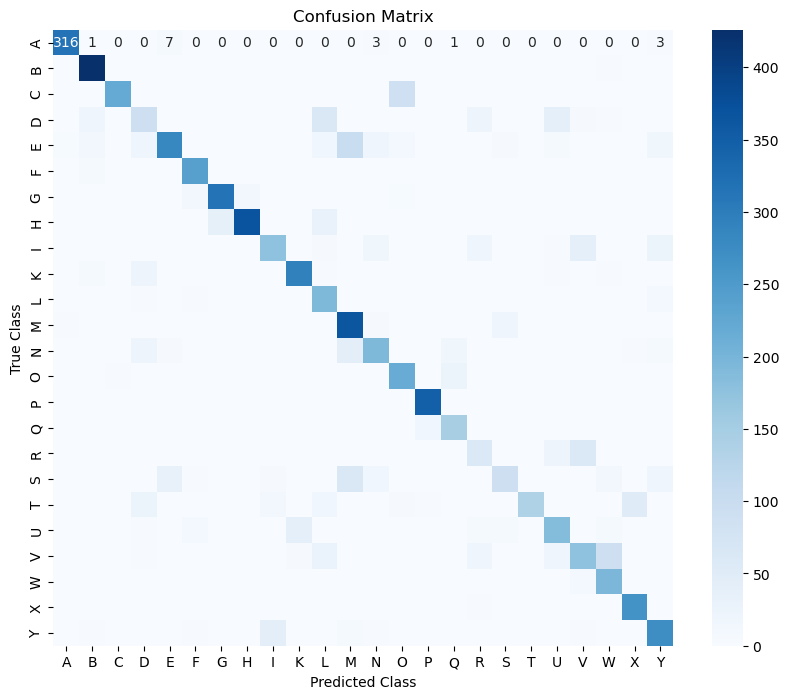

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

plot_training_history(history)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("Classification Report:\n")
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()
